In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import ode
from scipy.integrate import odeint
import numpy as np
import matplotlib

In [2]:
phi = 0.067
g_Ca = 4
V_3 = 12
V_4 = 17.4
E_Ca = 120
E_K = -84
E_L = -60
g_K = 8
g_L = 2
V_1 = -1.2
V_2 = 18
C_M = 20

def m_inf(V):
    return 0.5*(1.+np.tanh((V-V_1)/V_2))
def tau_n(V): 
    return 1./np.cosh((V-V_3)/(2*V_4))
def n_inf(V):
    return 0.5*(1.+np.tanh((V-V_3)/V_4))
    
def I_leak(V):
    return g_L*(V-E_L)
def I_K(V,n):
    return g_K*n*(V-E_K)
def I_Ca(V):
    return g_Ca*m_inf(V)*(V-E_Ca)

def MLneuronVF(X,t,I_ext=0):
    V,n = X
    dV = (I_ext-I_leak(V)-I_K(V,n)-I_Ca(V))/C_M
    dn = phi*(n_inf(V)-n)/tau_n(V)
    return dV,dn

def F_vec(t,y_vec,I_func):
    buffer = np.zeros(shape=(2,),dtype=np.float32)
    V = y_vec[0]
    N = y_vec[1]
    dy1dt = (I_func(t)-I_leak(V)-I_K(V,N)-I_Ca(V))/C_M
    dy2dt = phi*(n_inf(V)-N)/tau_n(V)
    buffer[0] = dy1dt
    buffer[1] = dy2dt
    return buffer

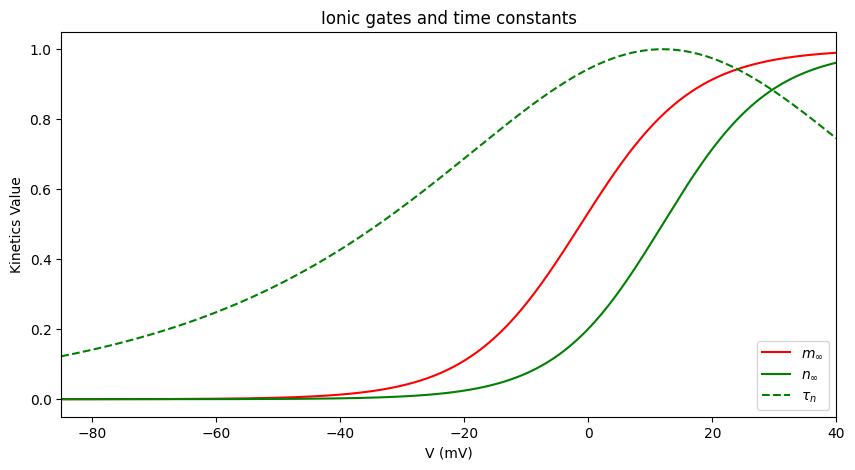

In [3]:
# plot ionic gate kinetics
Vsweep = np.linspace(-85.0, 40.0, 500)

plt.figure(figsize=(10,5));
plt.plot(Vsweep, m_inf(Vsweep), 'r-', label='$m_\\infty$');
plt.plot(Vsweep, n_inf(Vsweep), 'g-', label='$n_\\infty$');
plt.plot(Vsweep, tau_n(Vsweep), 'g--', label='$\\tau_n$');
plt.xlabel('V (mV)');
plt.ylabel('Kinetics Value');
plt.xlim(Vsweep[0], Vsweep[len(Vsweep)-1]);
plt.legend(loc='lower right');
plt.title('Ionic gates and time constants');

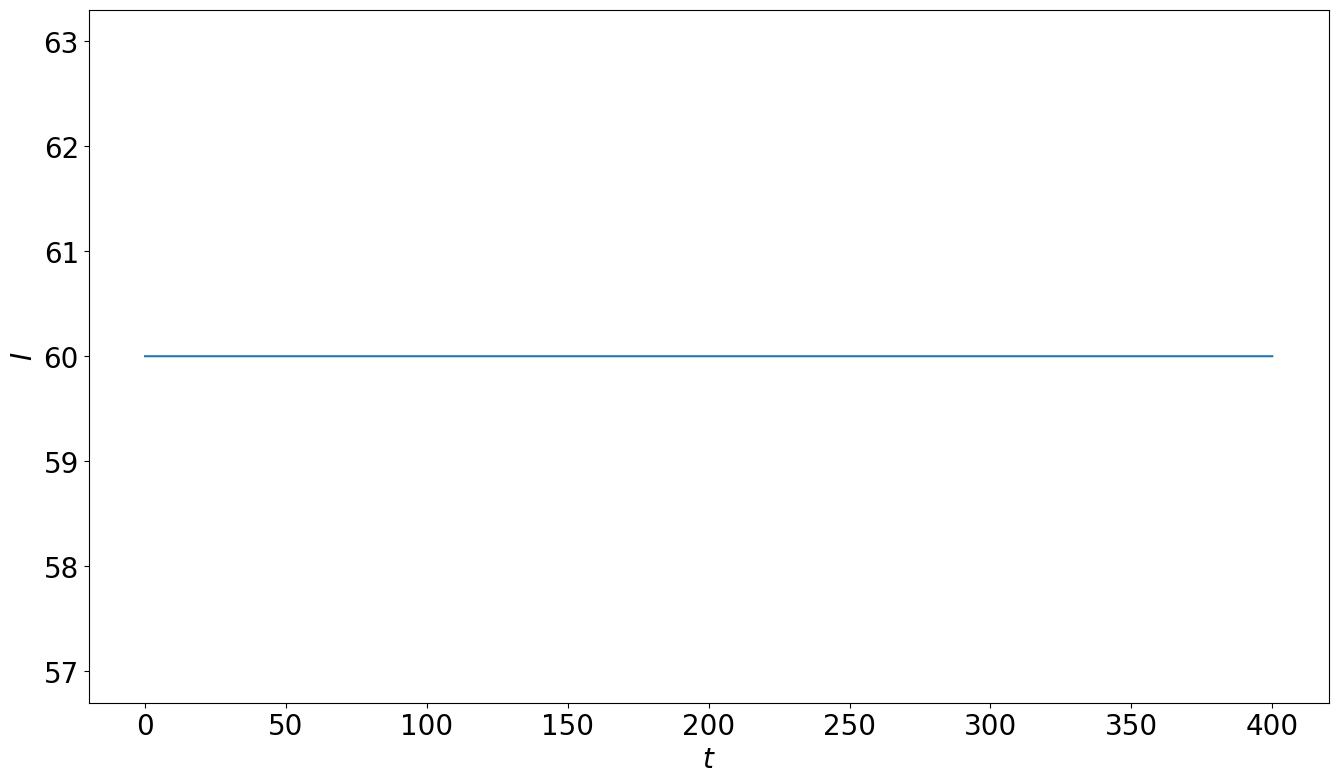

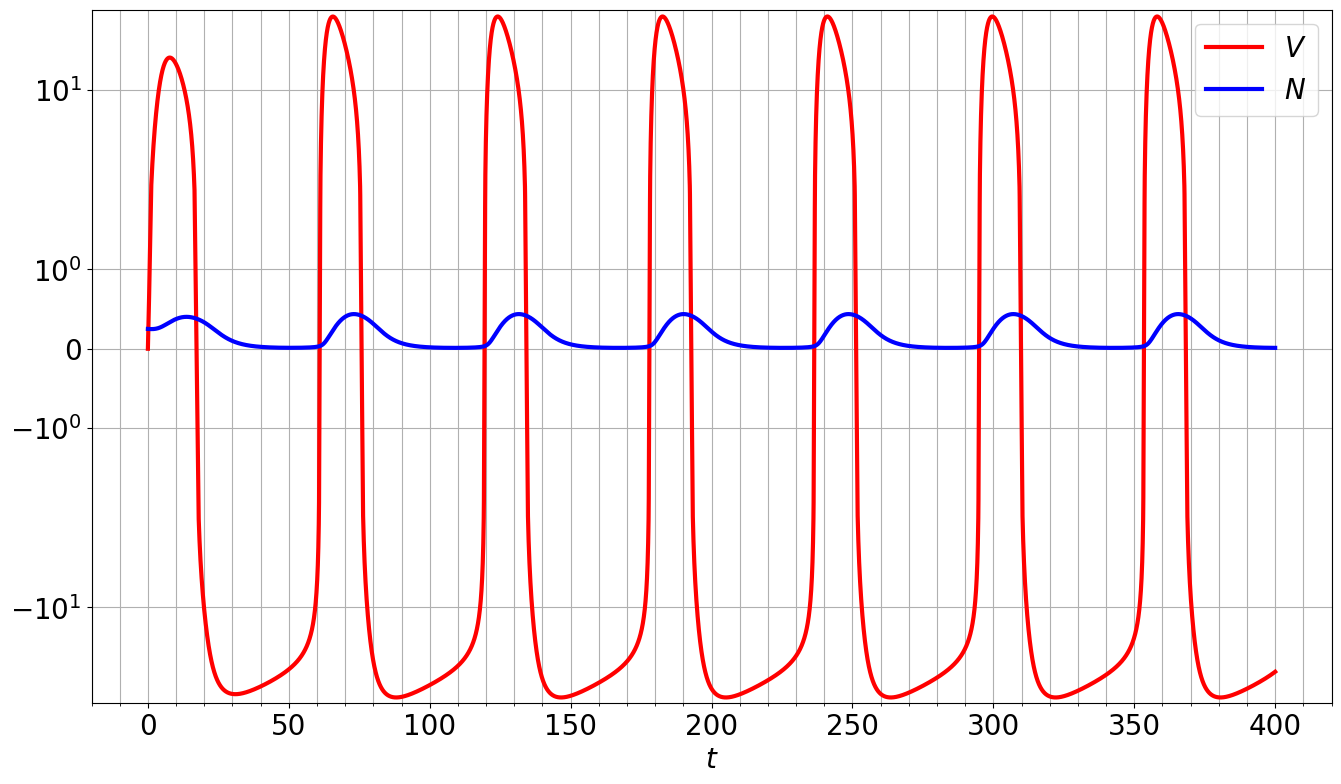

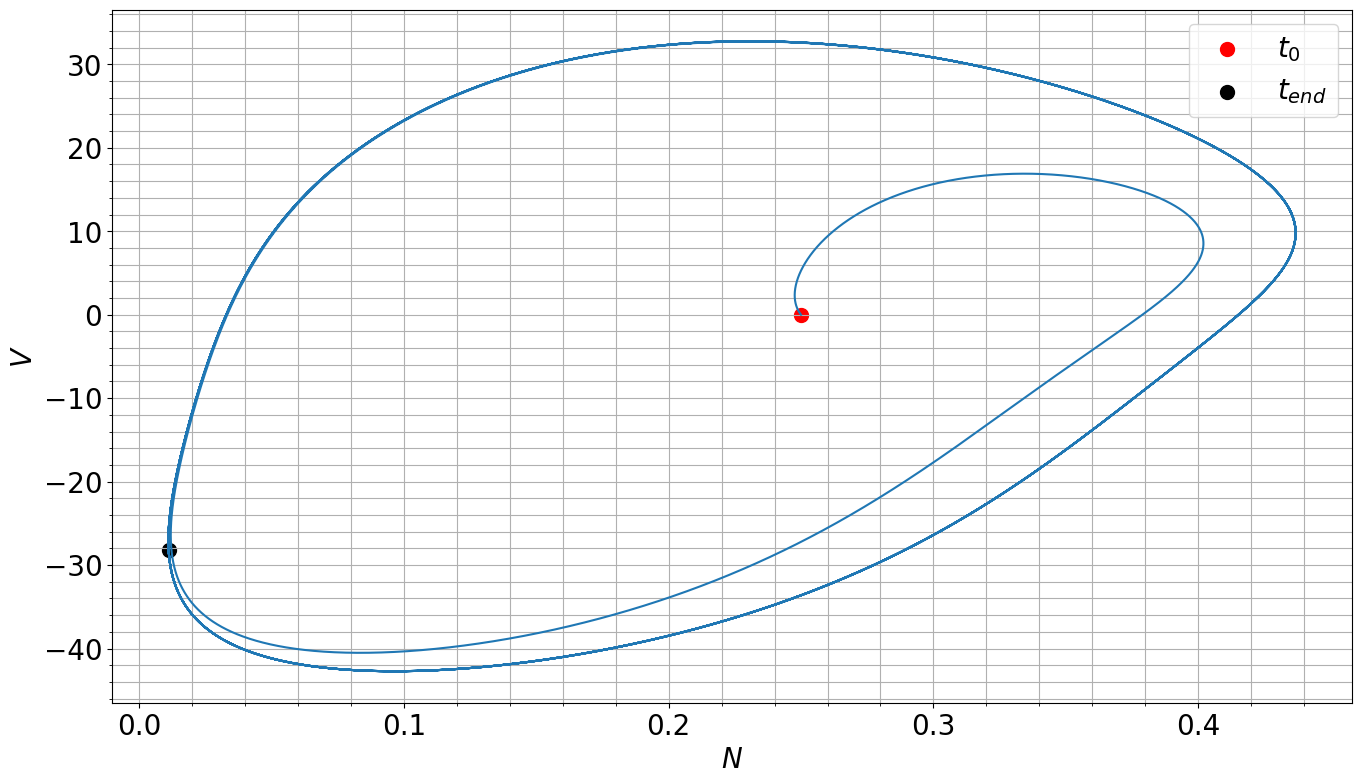

In [4]:
t_0 = 0.0
t_end = 400.0
tau_grid = 0.01
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(t_0,t_end,num=N) 
scale = 5
def I1(t):
    return 60.0
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
ax.plot(time_grid, [I1(t) for t in time_grid])
ax.set_ylabel(r'$I$')
ax.set_xlabel(r'$t$')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
k=2
start_point = np.array([-0, 0.25])

solutions = odeint(F_vec, start_point, time_grid, args=(I1,),tfirst=True)

time_sol = time_grid
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
y= solutions 
n_lines = len(solutions[0])
c = np.arange(1, n_lines + 1)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])
index_name = {0:'V',1:'N'}
index_color = {0:'r',1:'b'}
for i in range(k):
    ax.plot(time_sol, y[:,i],label = r'$' + index_name[i] +r'$',color=index_color[i],linewidth=3)
# fig.colorbar(cmap, ticks=c,ax=ax)
ax.legend()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize="20")
ax.set_yscale('symlog')
ax.grid(which = "both")
ax.minorticks_on()
# ax.set_ylabel(r'$t$')
ax.set_xlabel(r'$t$')

fig,ax = plt.subplots()
fig.set_size_inches(16,9)
x_ = y[:,1]
y_ = y[:,0]

start_dx = (x_[1]-x_[0])/tau_grid 
start_dy = (y_[1]-y_[0])/tau_grid 
dstart = np.array([start_dx,start_dy])
dstart = dstart/np.sum(dstart)
stop_dx = (x_[-1]-x_[-2])/tau_grid 
stop_dy = (y_[-1]-y_[-2])/tau_grid 
dstop = np.array([stop_dx,start_dy])
dstop = dstop/np.sum(dstop)

ax.plot(x_,y_)
ax.set_ylabel(r'$V$')
ax.set_xlabel(r'$N$')
ax.scatter([x_[0]],[y_[0]],c='r',s=100,label=r'$t_{0}$')
ax.scatter([x_[-1]],[y_[-1]],c='k',s=100,label=r'$t_{end}$')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
# ax.set_xscale('symlog')
# ax.set_yscale('symlog')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()

# Режим работы системы при различных значениях постоянного приложенного тока

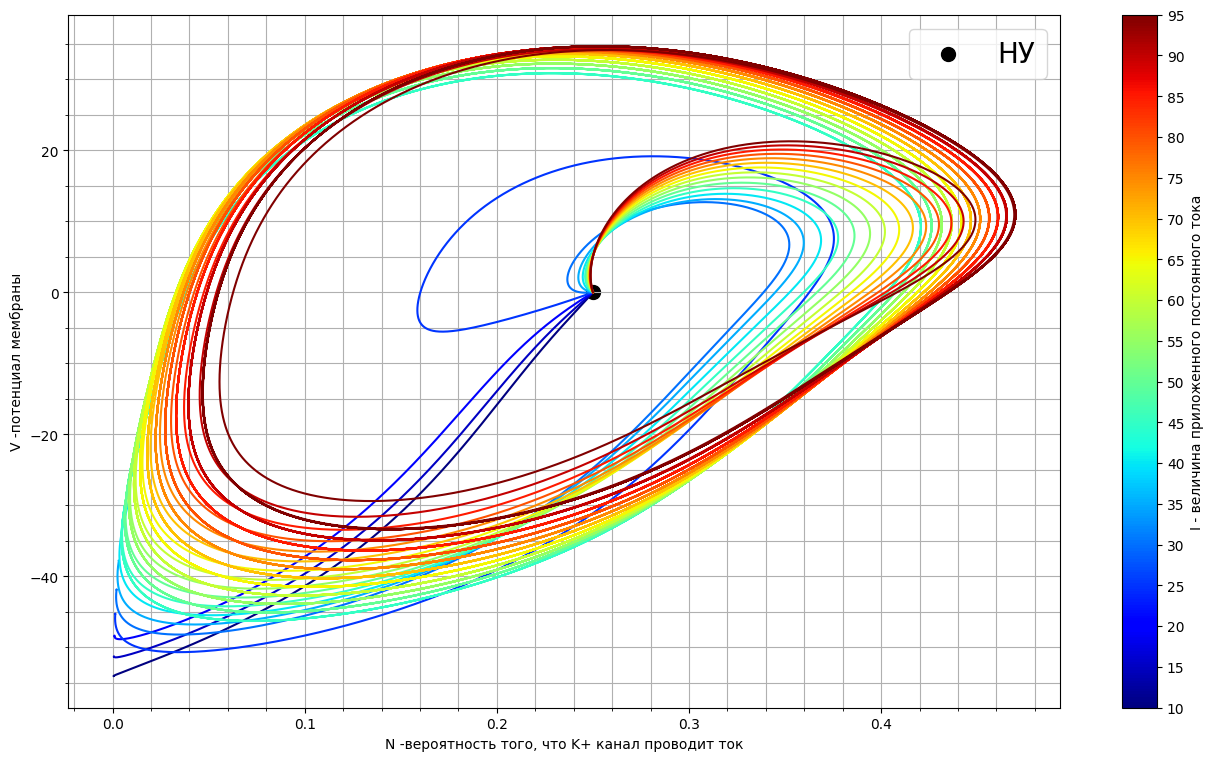

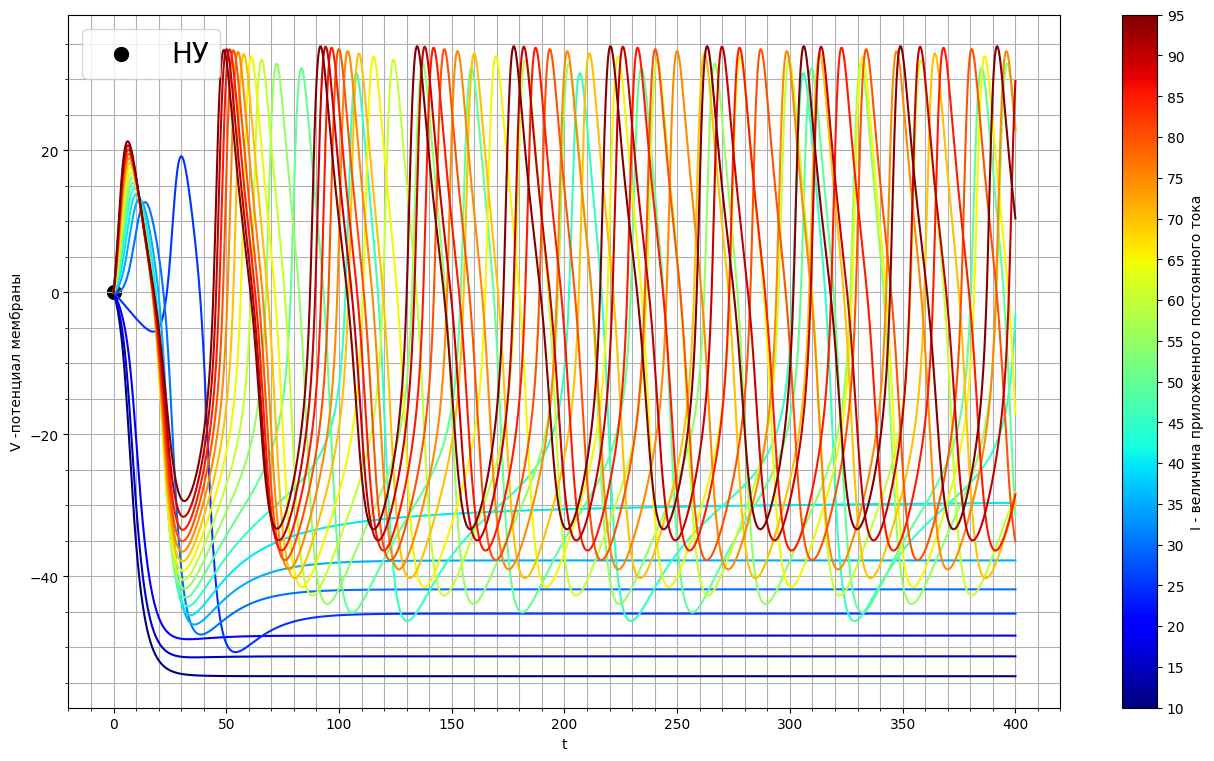

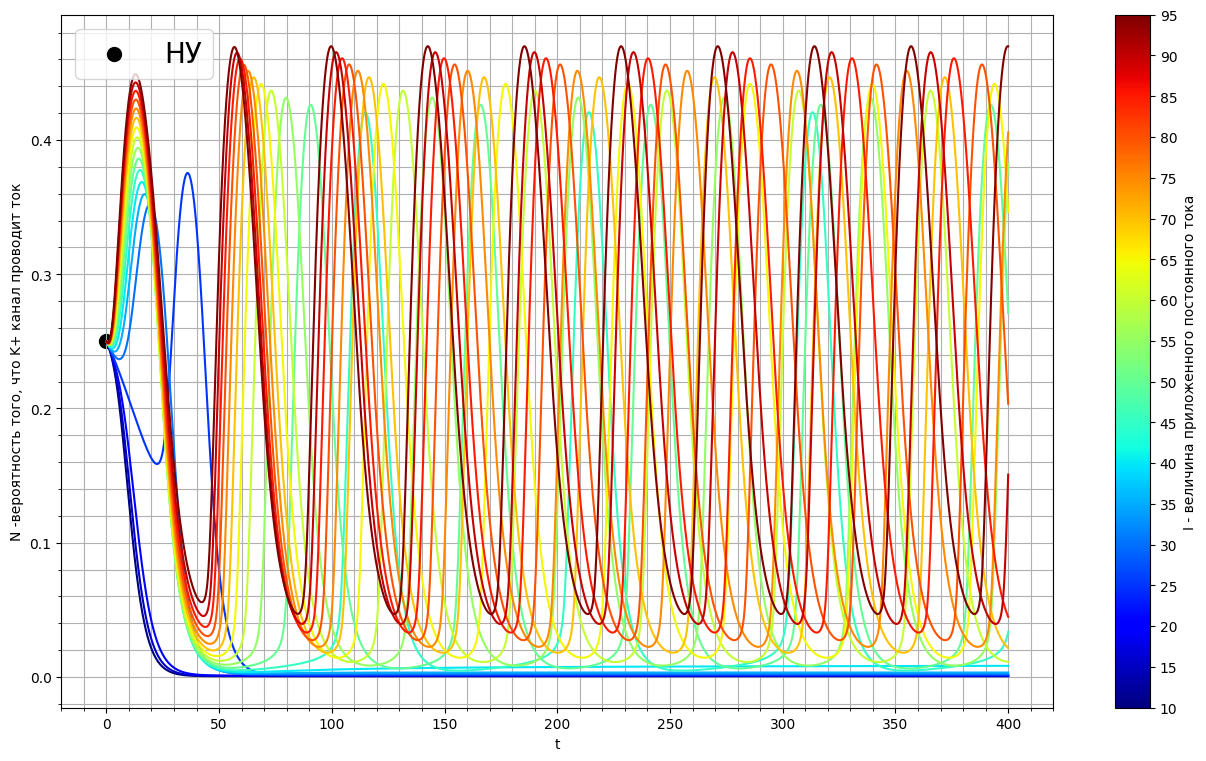

In [5]:
t_0 = 0.0
t_end = 400.0
tau_grid = 0.01
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(t_0,t_end,num=N) 

solutions__ = []
I_ampls = []
for i in range(10,100,5):
    I_ = lambda x: i
    I_ampls.append(i)
    start_point = np.array([-0, 0.25])
    solutions = odeint(F_vec, start_point, time_grid, args=(I_,),tfirst=True)
    solutions__.append(solutions)
    time_sol = time_grid

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = len(solutions__)
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i in range(len(solutions__)):
    y = solutions__[i]
    x_ = y[:,1]
    y_ = y[:,0] 
    ax.plot(x_, y_, c = cmap.to_rgba(i))

col_ = fig.colorbar(cmap, ticks=c,ax=ax)
col_.set_ticks(np.arange(len(solutions__)))
col_.set_ticklabels(I_ampls)
col_.set_label('I - величина приложенного постоянного тока')
ax.set_xlabel('N -вероятность того, что K+ канал проводит ток')
ax.set_ylabel('V -потенциал мембраны')
ax.scatter([start_point[1]],[start_point[0]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = len(solutions__)
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i in range(len(solutions__)):
    y = solutions__[i]
    x_ = time_grid
    y_ = y[:,0] 
    ax.plot(x_, y_, c = cmap.to_rgba(i))
col_ = fig.colorbar(cmap, ticks=c,ax=ax)
col_.set_ticks(np.arange(len(solutions__)))
col_.set_ticklabels(I_ampls)
col_.set_label('I - величина приложенного постоянного тока')
ax.set_xlabel('t')
ax.set_ylabel('V -потенциал мембраны')
ax.scatter([time_grid[0]],[start_point[0]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = len(solutions__)
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i in range(len(solutions__)):
    y = solutions__[i]
    x_ = time_grid
    y_ = y[:,1] 
    ax.plot(x_, y_, c = cmap.to_rgba(i))

col_ = fig.colorbar(cmap, ticks=c,ax=ax)
col_.set_ticks(np.arange(len(solutions__)))
col_.set_ticklabels(I_ampls)
col_.set_label('I - величина приложенного постоянного тока')
ax.set_xlabel('t')
ax.set_ylabel('N -вероятность того, что K+ канал проводит ток')
ax.scatter([time_grid[0]],[start_point[1]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

# Импульсный отклик системы

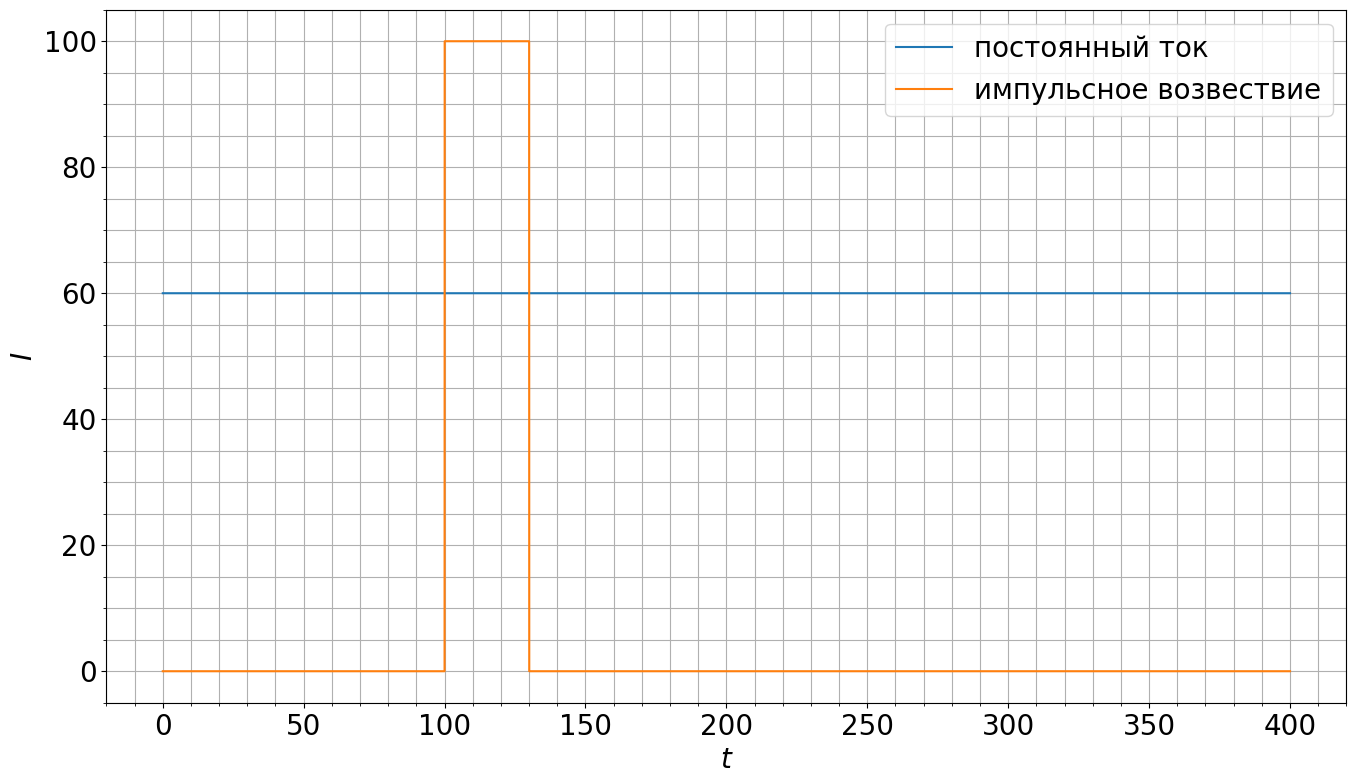

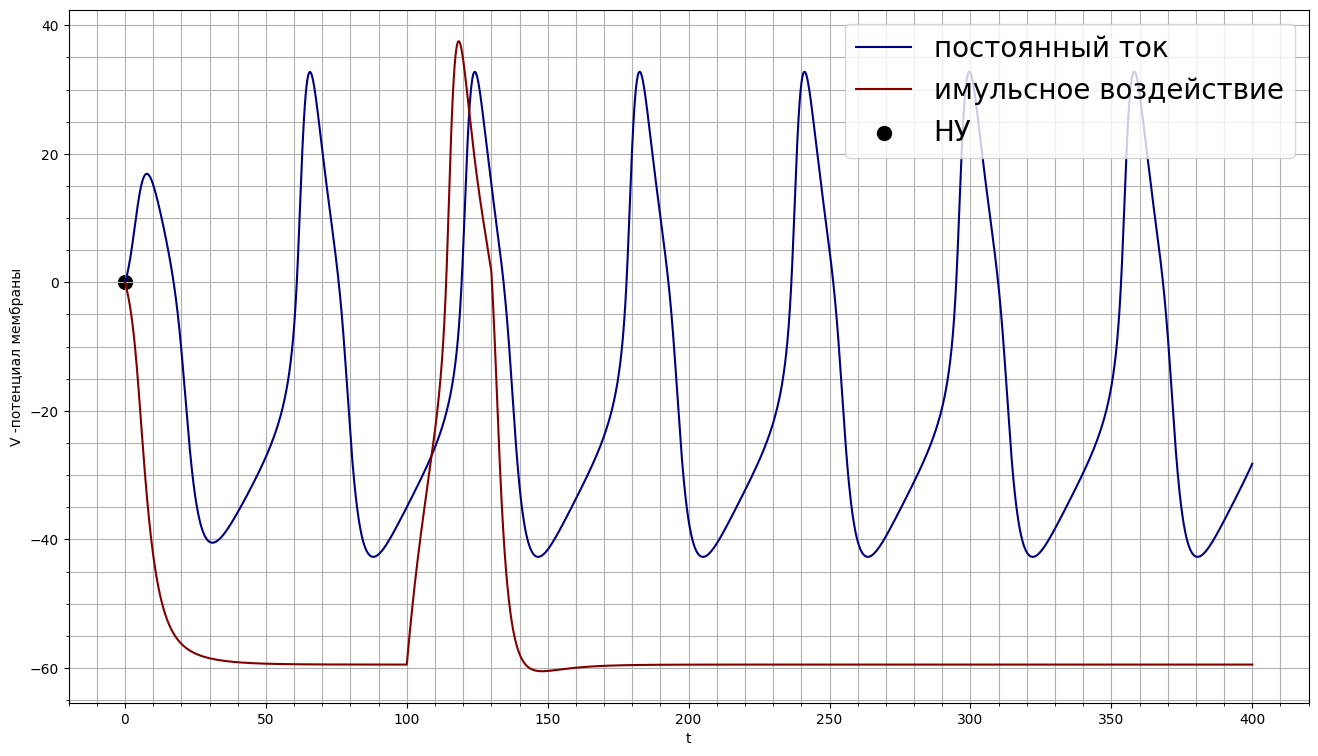

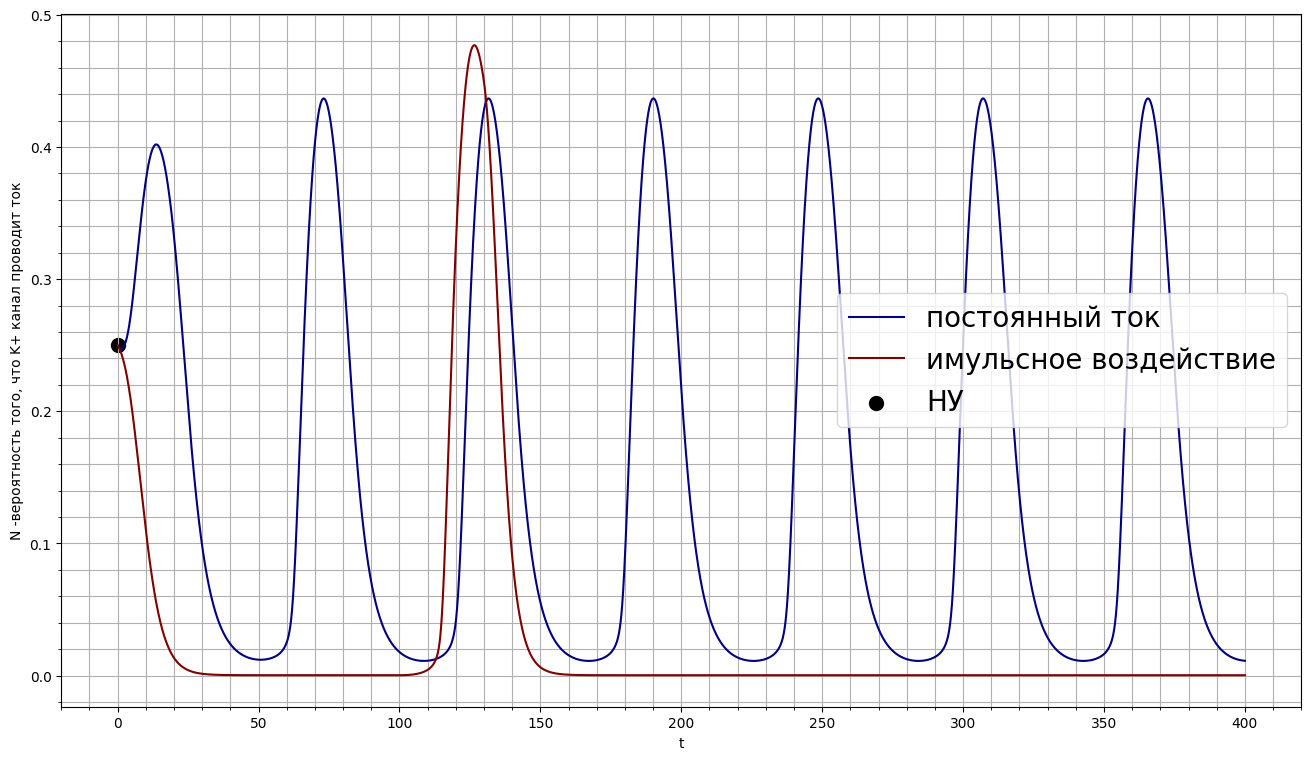

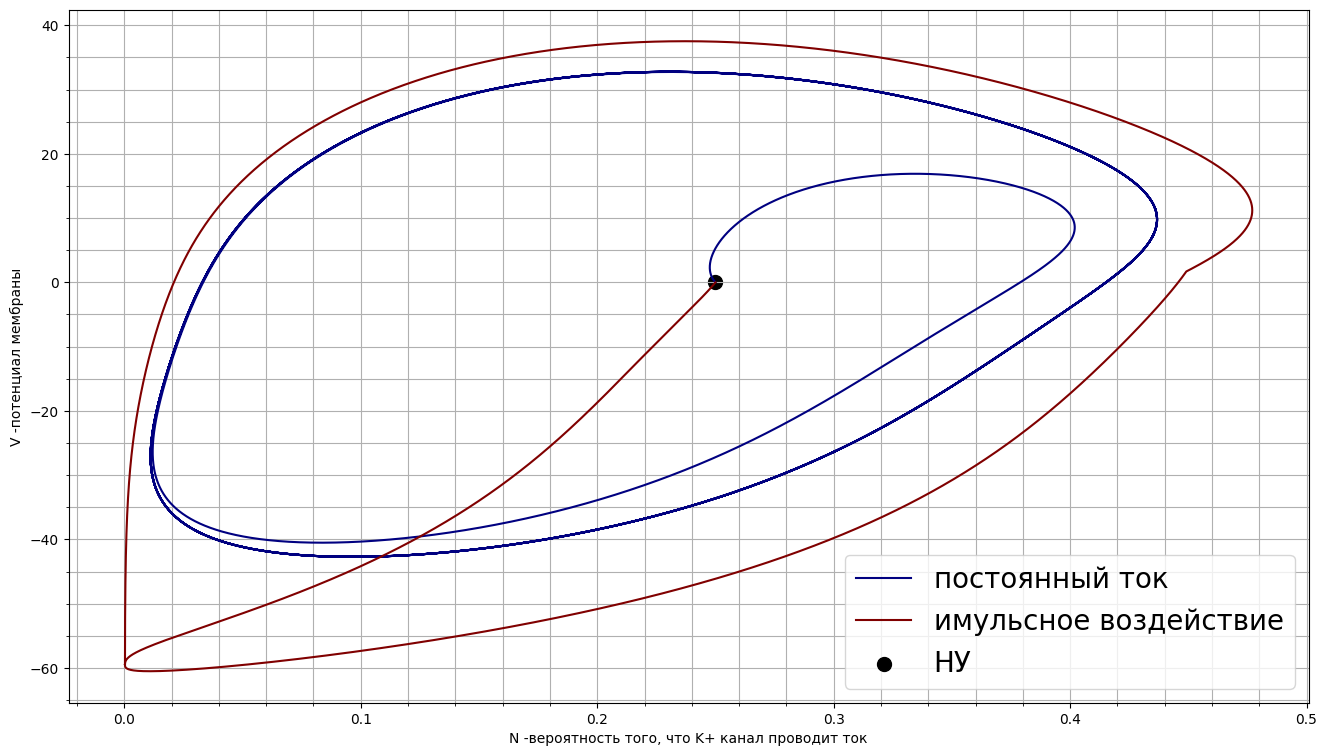

In [6]:
t_0 = 0.0
t_end = 400.0
tau_grid = 0.01
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(t_0,t_end,num=N) 
scale = 5
def I1(t):
    return 60.0
def Iimpl(t):
    if 100.0<=t<=130.0:
        return 100.0
    else:
        return 0.0
    
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
ax.plot(time_grid, [I1(t) for t in time_grid],label='постоянный ток')
ax.plot(time_grid, [Iimpl(t) for t in time_grid],label = 'импульсное возвествие')
ax.set_ylabel(r'$I$')
ax.set_xlabel(r'$t$')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
k=2
start_point = np.array([-0, 0.25])


solutions1 = odeint(F_vec, start_point, time_grid, args=(I1,),tfirst=True)
solutions_impl = odeint(F_vec, start_point, time_grid, args=(Iimpl,),tfirst=True)

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = 2
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

ax.plot(time_grid, solutions1[:,0], c = cmap.to_rgba(0),label = 'постоянный ток')
ax.plot(time_grid, solutions_impl[:,0], c = cmap.to_rgba(1), label = 'имульсное воздействие')

ax.set_xlabel('t')
ax.set_ylabel('V -потенциал мембраны')
ax.scatter([time_grid[0]],[start_point[0]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################


########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = 2
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

ax.plot(time_grid, solutions1[:,1], c = cmap.to_rgba(0),label = 'постоянный ток')
ax.plot(time_grid, solutions_impl[:,1], c = cmap.to_rgba(1), label = 'имульсное воздействие')

ax.set_xlabel('t')
ax.set_ylabel('N -вероятность того, что K+ канал проводит ток')
ax.scatter([time_grid[0]],[start_point[1]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = 2
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

ax.plot(solutions1[:,1],solutions1[:,0], c = cmap.to_rgba(0),label = 'постоянный ток')
ax.plot(solutions_impl[:,1],solutions_impl[:,0], c = cmap.to_rgba(1), label = 'имульсное воздействие')

ax.set_xlabel('t')
ax.scatter([start_point[1]],[start_point[0]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.set_xlabel('N -вероятность того, что K+ канал проводит ток')
ax.set_ylabel('V -потенциал мембраны')
ax.grid(which = "both")
ax.minorticks_on()
########################

# Импульсный отклик системы при различных параметрах импульсного входного сигнала

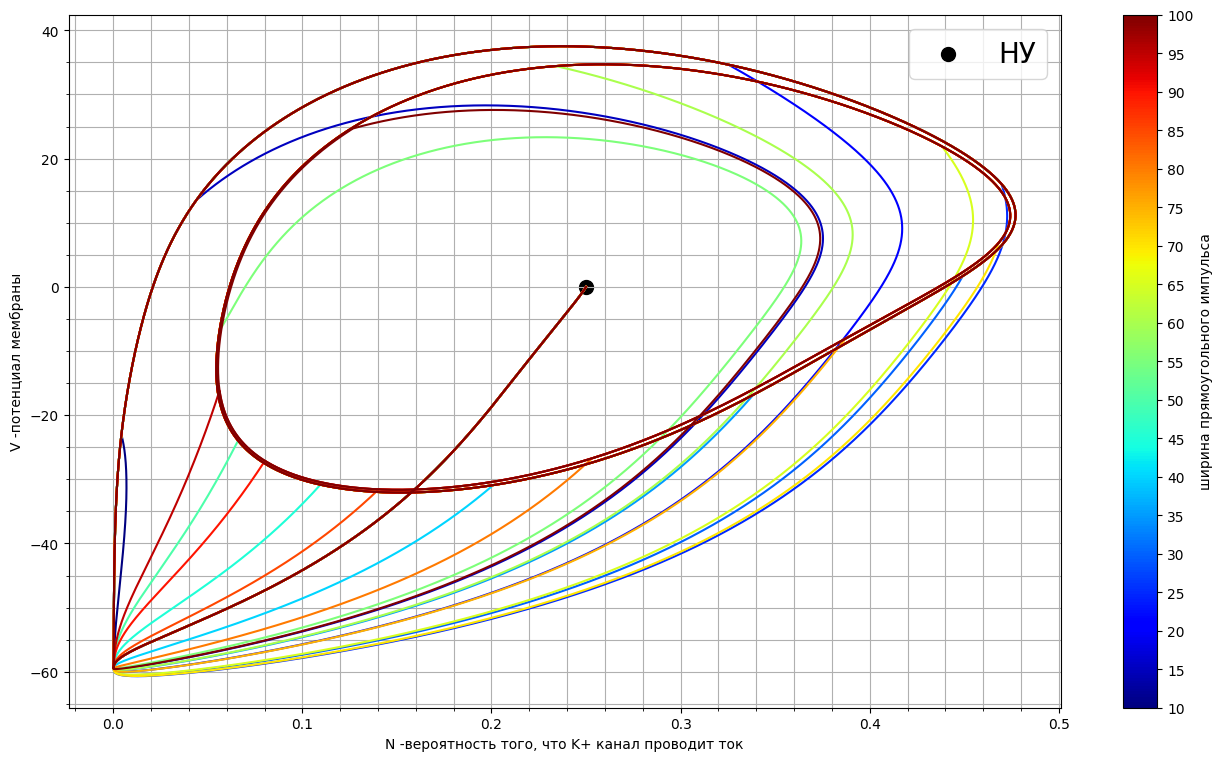

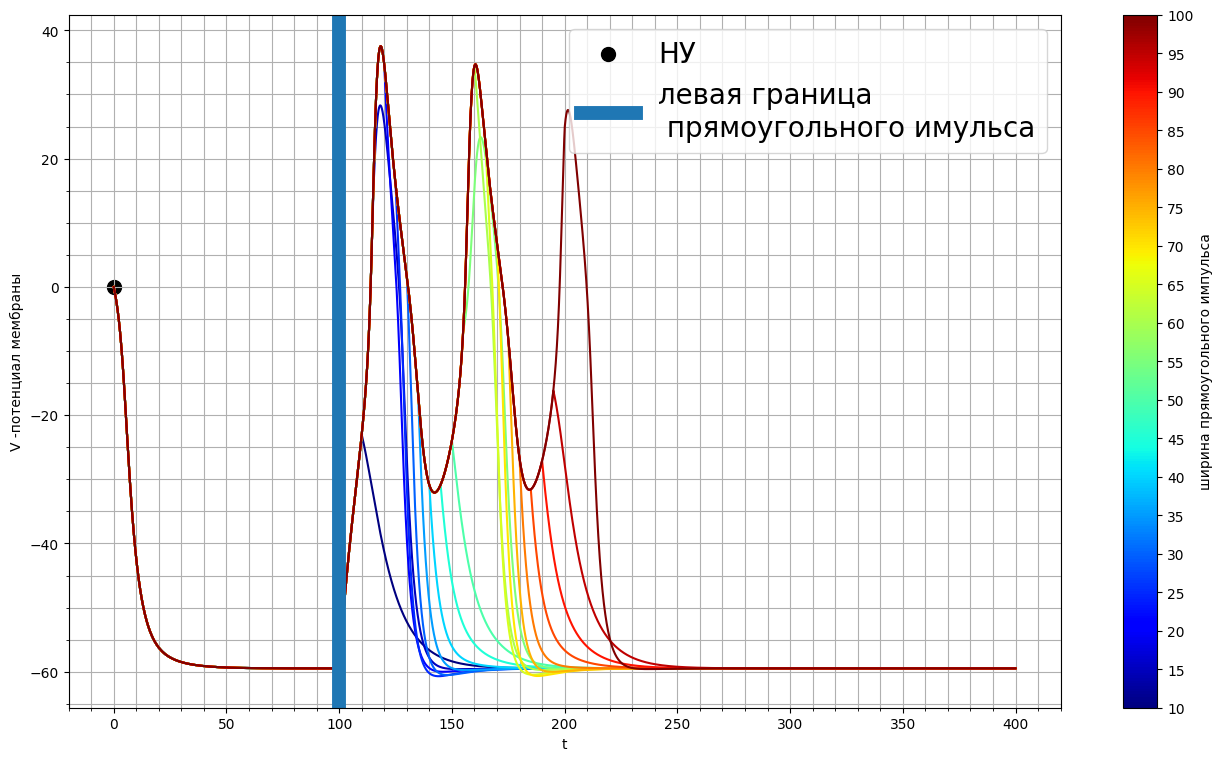

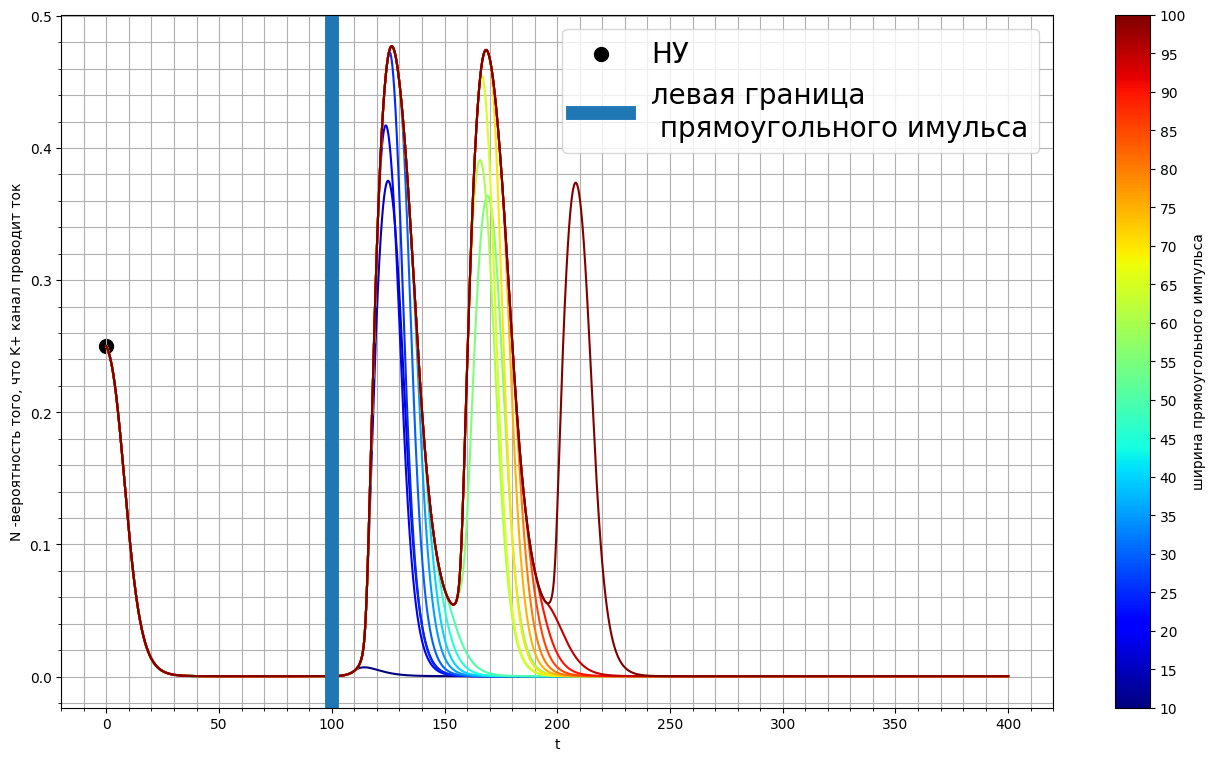

In [7]:
def Iimpl(t,a,b):
    if a<=t<=b:
        return 100.0
    else:
        return 0.0
t_0 = 0.0
t_end = 400.0
tau_grid = 0.01
N = int((t_end-t_0)/tau_grid)+1
time_grid = np.linspace(t_0,t_end,num=N) 

solutions__ = []
I_ampls = []
left_ = 100
for i in range(110,205,5):
    I_ = lambda x: Iimpl(x, left_,i)
    I_ampls.append(i)
    start_point = np.array([-0, 0.25])
    solutions = odeint(F_vec, start_point, time_grid, args=(I_,),tfirst=True)
    solutions__.append(solutions)
    time_sol = time_grid
I_ampls = np.array(I_ampls)

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = len(solutions__)
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i in range(len(solutions__)):
    y = solutions__[i]
    x_ = y[:,1]
    y_ = y[:,0] 
    ax.plot(x_, y_, c = cmap.to_rgba(i))

col_ = fig.colorbar(cmap, ticks=c,ax=ax)
col_.set_ticks(np.arange(len(solutions__)))
col_.set_ticklabels(I_ampls-left_)
col_.set_label('ширина прямоугольного импульса')
ax.set_xlabel('N -вероятность того, что K+ канал проводит ток')
ax.set_ylabel('V -потенциал мембраны')
ax.scatter([start_point[1]],[start_point[0]],s=100,c='k',label='НУ')
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = len(solutions__)
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i in range(len(solutions__)):
    y = solutions__[i]
    x_ = time_grid
    y_ = y[:,0] 
    ax.plot(x_, y_, c = cmap.to_rgba(i))
col_ = fig.colorbar(cmap, ticks=c,ax=ax)
col_.set_ticks(np.arange(len(solutions__)))
col_.set_ticklabels(I_ampls-left_)
col_.set_label('ширина прямоугольного импульса')
ax.set_xlabel('t')
ax.set_ylabel('V -потенциал мембраны')
ax.scatter([time_grid[0]],[start_point[0]],s=100,c='k',label='НУ')
ax.axvline(left_, label = 'левая граница \n прямоугольного имульса',lw=10)

ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

########################
fig,ax = plt.subplots()
fig.set_size_inches(16,9)
n_lines = len(solutions__)
c = np.arange(n_lines)
# c = np.copy(I_ampls)
norm = matplotlib.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i in range(len(solutions__)):
    y = solutions__[i]
    x_ = time_grid
    y_ = y[:,1] 
    ax.plot(x_, y_, c = cmap.to_rgba(i))

col_ = fig.colorbar(cmap, ticks=c,ax=ax)
col_.set_ticks(np.arange(len(solutions__)))
col_.set_ticklabels(I_ampls-left_)
col_.set_label('ширина прямоугольного импульса')
ax.set_xlabel('t')
ax.set_ylabel('N -вероятность того, что K+ канал проводит ток')
ax.scatter([time_grid[0]],[start_point[1]],s=100,c='k',label='НУ')
ax.axvline(left_, label = 'левая граница \n прямоугольного имульса',lw=10)
ax.legend(fontsize="20")
ax.grid(which = "both")
ax.minorticks_on()
########################

# Фазовые портреты при различных параметрах системы

# Стационарная точка